# 跌倒检测项目说明文档

## 项目概述

本项目旨在开发一个基于深度学习的跌倒检测模型，通过输入图片来判断用户是否处于跌倒、行走或坐姿状态。项目采用多种迁移学习模型，并结合注意力机制和Focal Loss进行创新性改进，以提升模型的检测性能。

## 数据加载与预处理

### 数据路径

项目使用的数据集路径如下：
- 训练图片路径：`train_img_path`
- 训练标签路径：`train_label_path`
- 验证图片路径：`val_img_path`
- 验证标签路径：`val_label_path`

### 数据加载

数据加载过程中，首先获取图片和标签文件列表并对其进行排序。项目中定义了`load_data`函数，用于从指定目录中加载图像及其对应的标签信息。图片文件和标签文件分别位于不同的目录中，通过读取这些文件并对其进行处理，将数据组织成所需的格式。

在加载图片时，首先获取图片文件的名称列表，并对这些名称进行排序，以确保每次加载时的顺序一致。接着，依次读取每个图片文件，使用`plt.imread`函数将其加载为数组格式。对于标签文件，通过打开并读取其内容，将标签信息解析为边界框（bounding boxes），每个边界框包含类别标签及其在图像中的位置和大小。通过解析标签文件中的每一行，提取出边界框的具体信息并进行相应的转换，将其转换为像素坐标系下的值。

在提取出边界框后，根据边界框的位置信息从原图像中裁剪出对应的图像区域，并将其存储在一个列表中。同时，将对应的类别标签也存储在另一个列表中。最终，这两个列表将分别包含所有图像区域及其对应的类别标签。

### 数据预处理

为了将图像调整为模型所需的输入尺寸，项目定义了一个`preprocess_images`函数。该函数的目的是将所有图像调整为统一的大小，并对像素值进行归一化处理。这样可以确保输入到模型中的数据格式一致，从而提高模型的训练效果。

首先，`preprocess_images`函数会遍历每一张图像，并使用`cv2.resize`函数将其调整为指定的尺寸（128×128像素）。调整尺寸的过程需要保持图像的纵横比，并在必要时进行填充或裁剪。调整后的图像存储在一个新的数组中，以便后续使用。

接下来，`preprocess_images`函数对调整后的图像进行归一化处理。归一化的目的是将像素值缩放到[0, 1]的范围内，这有助于加速模型的训练并提高模型的收敛速度。具体来说，函数会将每个像素值除以255，从而将像素值从[0, 255]缩放到[0, 1]。处理完成后，所有预处理过的图像将存储在`X_train`、`y_train`、`X_val`和`y_val`变量中，分别对应训练集和验证集的数据及其标签。

### 数据展示

为了便于理解和分析数据，项目定义了一个`display_random_images`函数用于随机显示训练集中的图像及其对应的标签。此函数通过生成随机索引，选取相应的图像并显示其标签，以便更直观地查看数据的分布和标签的准确性。

首先，`display_random_images`函数会生成指定数量的随机索引，这些索引用于从图像和标签数组中随机选取样本。然后，函数会创建一个绘图窗口，并在窗口中以网格形式显示选取的图像。对于每一张图像，函数会显示其对应的标签，标签可以是文字形式的类别名称，从而直观地展示图像的分类结果。

为了更好地展示图像和标签，函数会设置每张图像的标题为其对应的类别标签，并关闭图像的坐标轴显示，使图像展示更为简洁和清晰。通过这种方式，可以直观地了解训练数据的分布情况，并对数据质量进行初步评估。

## 模型选择与设计

### 迁移学习模型

迁移学习是一种将从一个任务中学到的知识应用到不同但相关的任务中的技术。在计算机视觉中，迁移学习通常涉及使用在大型数据集（如ImageNet）上预训练的深度学习模型，然后将这些预训练模型的权重和特征应用到新的任务中。通过迁移学习，可以显著减少训练时间和对大量标注数据的需求，同时提高模型的泛化能力和准确性。本项目选择了多种迁移学习模型，包括VGG16、InceptionV3、MobileNetV2、DenseNet121、Xception、NASNetMobile、VGG19和InceptionResNetV2。这些模型均在ImageNet数据集上预训练，具有较强的特征提取能力。每个模型的主要特点如下：

- **VGG16**  
  VGG16具有16个权重层，其结构简单且层次分明，适用于小数据集的特征提取。它通过多个3x3卷积层的堆叠捕捉图像细节，提升了分类效果。然而，其参数量较大，对计算资源要求较高。

- **InceptionV3**  
  InceptionV3使用了Inception模块，通过在不同尺度上进行卷积操作，有效提升了计算效率和模型性能。其结构复杂但灵活，通过减少参数数量提高了计算效率，适合处理大规模数据集。

- **MobileNetV2**  
  MobileNetV2是一种轻量级模型，专为移动和嵌入式设备设计。它使用深度可分离卷积，显著减少了参数和计算量，同时保持了较高的分类精度，非常适合资源受限的环境。

- **DenseNet121**  
  DenseNet121通过密集连接各层，提高了特征传递和复用效率，减轻了梯度消失问题。其结构紧凑，每一层都直接接收所有前面层的特征，从而提升了模型的表现和训练速度。

- **Xception**  
  Xception采用深度可分离卷积，显著减少了参数数量和计算量。其架构基于极端的Inception模块，充分利用了卷积分解技术，使得模型在保持高性能的同时，具备更好的计算效率。

- **NASNetMobile**  
  NASNetMobile通过自动化神经网络结构搜索，优化了模型结构。它采用强化学习的方法，根据性能指标自动设计和调整网络架构，从而在效率和效果之间达到了良好的平衡。

- **VGG19**  
  VGG19在VGG16的基础上增加了更多的卷积层，进一步提升了模型的表达能力。尽管参数量更大，但其层次更加丰富，能够捕捉到更为复杂的特征，适合对精度要求较高的任务。

- **InceptionResNetV2**  
  InceptionResNetV2结合了Inception和ResNet的优点，通过加入残差连接，增强了信息流动和梯度传递能力。其复杂的结构使得模型性能大幅提升，适用于高要求的图像分类任务。

## 创新点

### 多头自注意力机制

本项目在模型中引入了多头自注意力机制。其核心思想是通过多头的方式将输入映射到多个子空间，在每个子空间中独立进行注意力计算，然后将各子空间的结果拼接起来，从而增强模型的特征表达能力。
多头自注意力机制首先将输入的特征表示（矩阵形式）通过线性变换分别映射到查询（Query）、键（Key）和值（Value）三个空间。然后，在每个子空间中，通过计算查询与键的点积，得到注意力权重，并将该权重应用于值，从而得到注意力输出。

多头自注意力机制的具体公式如下：
$$ \text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right) V $$
其中，$Q$、$K$和$V$分别表示查询、键和值矩阵，$d_k$为键矩阵的维度。计算过程如下：

1. **线性变换**：将输入特征通过线性变换分别得到查询矩阵 $Q$、键矩阵 $K$ 和值矩阵 $V$。这一步的目的是将输入特征映射到不同的子空间中，以便在这些子空间中进行注意力计算。

2. **点积相似度**：计算查询矩阵 $Q$ 和键矩阵 $K$ 的点积，并除以键矩阵维度的平方根 $ \sqrt{d_k} $ 进行缩放，得到相似度得分。

3. **软最大化**：对相似度得分进行softmax操作，得到注意力权重，这些权重表示输入序列中各元素之间的相对重要性。

4. **加权求和**：将注意力权重应用于值矩阵 $V$，得到加权求和值，即注意力输出。

5. **多头拼接**：将各个子空间中的注意力输出拼接起来，得到最终的多头自注意力输出。

通过上述步骤，多头自注意力机制能够在多个子空间中独立地捕捉输入序列的全局信息，增强模型的特征表达能力。

### Focal Loss

为了处理类别不平衡问题，本项目采用了Focal Loss作为损失函数。Focal Loss是一种改进的交叉熵损失函数，专为解决类别不平衡问题设计。类别不平衡会导致模型更倾向于预测多数类别，从而忽略少数类别样本。Focal Loss通过在标准交叉熵损失的基础上增加调节因子，使得模型在训练时更关注难分类的样本，从而提高模型的鲁棒性。

Focal Loss的公式如下：
$$ \text{FL}(p_t) = -\alpha_t (1 - p_t)^\gamma \log(p_t) $$
其中，$ \alpha_t $ 为平衡因子，$ \gamma $ 为调节因子，$ p_t $ 为模型对正确类别的预测概率。具体解释如下：

1. **平衡因子 $ \alpha_t $**：用于平衡不同类别的损失，防止多数类别的损失对总损失的贡献过大。通过设置合适的平衡因子，可以使得模型在训练过程中更加关注少数类别的样本。

2. **调节因子 $ \gamma $**：用于调节难易样本的影响程度。当 $ \gamma = 0 $ 时，Focal Loss退化为标准的交叉熵损失。随着 $ \gamma $ 的增大，Focal Loss会使得模型更加关注难分类的样本，因为这些样本的预测概率 $ p_t $ 较低，使得 $ (1 - p_t)^\gamma $ 项的值较大，从而增大这些样本的损失。

3. **预测概率 $ p_t $**：表示模型对正确类别的预测概率。Focal Loss通过调整 $ p_t $ 的影响，来动态地平衡难易样本的损失。

Focal Loss的通过增加对难分类样本的关注，可以减轻类别不平衡对模型训练的负面影响。

## 模型训练与评估

### 模型编译与训练

在训练过程中，每个模型的配置和训练过程如下：

- **优化器**  
  使用Adam优化器，该优化器结合了动量和自适应学习率策略，能够加速训练并提高模型的收敛速度。Adam优化器的默认参数设置为学习率 `learning_rate=0.001`、`beta_1=0.9`、`beta_2=0.999` 和 `epsilon=1e-07`。

- **损失函数**  
  采用Focal Loss损失函数，该函数专为处理类别不平衡问题设计。公式如下：
  $$ \text{FL}(p_t) = -\alpha_t (1 - p_t)^\gamma \log(p_t) $$
  其中，$ \alpha_t $ 为平衡因子，设为0.25；$ \gamma $ 为调节因子，设为2.0。

- **训练过程**  
  每个模型在训练集上训练20个周期（`epochs=20`）。

### 模型评估

训练完成后，模型在验证集上进行评估，并计算以下指标：

- **准确率（Accuracy）**  
  准确率是指模型预测正确的样本占所有样本的比例。计算公式如下：
  $$ \text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN} $$
  其中，$ TP $ 为真正例，$ TN $ 为真负例，$ FP $ 为假正例，$ FN $ 为假负例。

- **精确率（Precision）**  
  精确率是指模型预测为正类的样本中，实际为正类的比例。计算公式如下：
  $$ \text{Precision} = \frac{TP}{TP + FP} $$

- **召回率（Recall）**  
  召回率是指实际为正类的样本中，被模型正确预测为正类的比例。计算公式如下：
  $$ \text{Recall} = \frac{TP}{TP + FN} $$

- **F1分数（F1-score）**  
  F1分数是精确率和召回率的调和平均数，用于综合评价模型的分类性能。计算公式如下：
  $$ \text{F1-score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} $$

通过以上指标，可以全面评估模型在验证集上的表现，了解模型在分类任务中的性能优劣。


### 混淆矩阵与ROC曲线

为了更直观地展示模型的分类性能，本项目绘制了混淆矩阵和ROC曲线。

- **混淆矩阵**

混淆矩阵是一个方形矩阵，用于评估分类模型的性能。矩阵的每一行代表实际的类别，每一列代表预测的类别。具体来说：

  - **对角线元素**表示正确分类的样本数，即模型预测与实际类别一致的样本数。
  - **非对角线元素**表示分类错误的样本数。每个元素（i, j）表示实际类别为i但被预测为j的样本数。

通过混淆矩阵，我们可以直观地看到模型在哪些类别上表现良好，以及在哪些类别上容易出错。

- **ROC曲线**

ROC（Receiver Operating Characteristic）曲线用于评估分类模型在不同阈值下的性能。它通过绘制不同阈值下的真阳性率（TPR）和假阳性率（FPR），展示模型的分类能力。

  - **真阳性率（TPR）**：也称为召回率，表示实际为正类的样本中，被正确预测为正类的比例。公式为：
    $$ \text{TPR} = \frac{TP}{TP + FN} $$

  - **假阳性率（FPR）**：表示实际为负类的样本中，被错误预测为正类的比例。公式为：
    $$ \text{FPR} = \frac{FP}{FP + TN} $$

通过绘制ROC曲线，可以观察到模型在不同阈值下的表现。曲线下面积（AUC）越大，模型的性能越好。理想的ROC曲线接近左上角，表示高TPR和低FPR。

## 结果与比较

通过对不同模型的评估结果进行比较，可以发现各模型在跌倒检测任务上的表现差异。项目中使用的评价指标包括准确率、精确率、召回率和F1分数，通过绘制柱状图对比各模型的性能，从而选择最优模型。


### Code

In [2]:
import os
# Load necessary packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
import platform
if platform.system() == "Windows":
    plt.rcParams['font.family'] = ['SimHei'] # Set font for Windows
elif platform.system() == "Darwin":
    plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']  # Set font for MacOS
plt.rcParams['axes.unicode_minus']=False 

import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2
from tensorflow.keras import layers, models
import cv2
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import label_binarize
import random
import os

data_source = r'/kaggle/input/fall-dataset-yolov/fall_dataset_ Roboflow'

# Data paths
train_img_path = os.path.join(data_source,'images/train/')
train_label_path = os.path.join(data_source,'labels/train/')
val_img_path = os.path.join(data_source,'images/val/')
val_label_path = os.path.join(data_source,'labels/val/')

print(train_img_path)
def load_data(img_path, label_path):
    """
    Load images and corresponding labels from the specified directories.

    Parameters:
    img_path (str): Path to the directory containing image files.
    label_path (str): Path to the directory containing label files.

    Returns:
    images (list): List of image arrays.
    labels (list): List of corresponding labels.
    """
    # Get list of image and label files
    img_files = os.listdir(img_path)
    img_files.sort()  # Sort image files to ensure consistent order
    label_files = os.listdir(label_path)
    label_files.sort()  # Sort label files to ensure consistent order

    images = []
    labels = []

    # Iterate through each image file
    for i in range(len(img_files)):
        # Read the image
        img = plt.imread(img_path + img_files[i])
        
        # Read the corresponding label file
        with open(label_path + label_files[i], 'r') as file:
            r = file.readlines()
        
        bounding_boxes = []
        # Process each line in the label file
        for j in r:
            j = j.split()
            bounding_boxes.append([int(j[0]), float(j[1]), float(j[2]), float(j[3]), float(j[4])])
        
        # Extract each bounding box from the label
        for box in bounding_boxes:
            image_height, image_width, _ = img.shape
            xmin, ymin, width, height = box[1:]
            
            # Convert bounding box coordinates to pixel values
            xmin = int(xmin * image_width)
            ymin = int(ymin * image_height)
            width = int(width * image_width)
            height = int(height * image_height)
            
            # Append the class label and corresponding image region
            labels.append(box[0])
            images.append(img[ymin-height//2:ymin+height//2, xmin-width//2:xmin+width//2])
    
    return images, labels

# usage of the load_data function
train_images, train_labels = load_data(train_img_path, train_label_path)
val_images, val_labels = load_data(val_img_path, val_label_path)

# Preprocess images to the preferred size
pref_size = (128, 128)
def preprocess_images(images):
    for i in range(len(images)):
        images[i] = cv2.resize(images[i], pref_size)
    return np.array(images) / 255.0

# Preprocess train and validation images
X_train = preprocess_images(train_images)
y_train = np.array(train_labels)
X_val = preprocess_images(val_images)
y_val = np.array(val_labels)

2024-09-07 00:46:37.083165: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-07 00:46:37.083343: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-07 00:46:37.274242: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/fall-dataset-yolov/fall_dataset_ Roboflow/images/train/


In [3]:
if len(np.unique(y_train))==2:
    label_names =  ['Fall Detected', 'NoFall Detected']
else:
    # Mapping of labels to class names
    label_names = ['Fall Detected', 'Walking', 'Sitting']

global num_classes
num_classes = len(label_names)

In [ ]:
import matplotlib.pyplot as plt



# Function to display random images with labels
def display_random_images(images, labels, num_images=9):
    """
    Display a grid of random images with their corresponding labels.

    Parameters:
    images (array): Array of image data.
    labels (array): Array of labels corresponding to the images.
    num_images (int): Number of images to display. Default is 9.
    """
    plt.figure(figsize=(10, 10))
    
    np.random.seed(3)
    # Generate random indices
    indices = np.random.choice(len(images), num_images, replace=False)
    
    for i, index in enumerate(indices):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[index])
        plt.title(label_names[labels[index]])
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Display random images from the training set
display_random_images(X_train, y_train, num_images=9)

Training DenseNet201 model...
Restored best model weights
Evaluation...


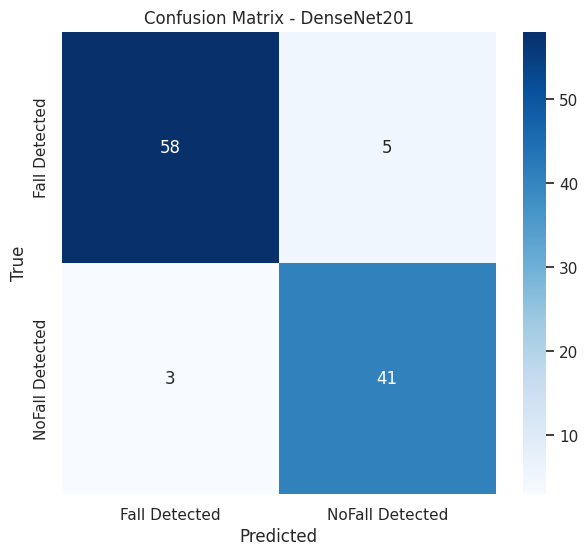

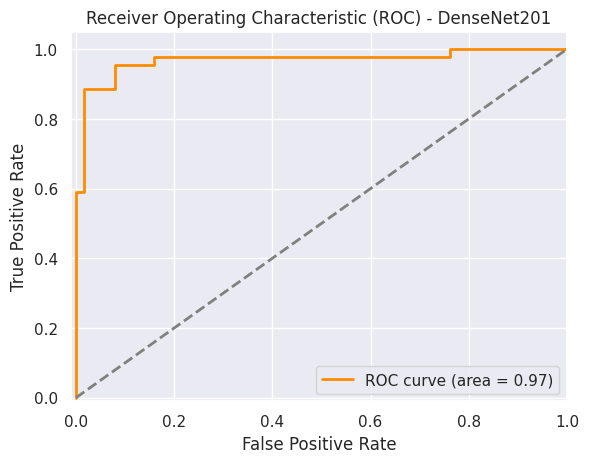

Training ResNet50 model...


In [ ]:
from tensorflow.keras.applications import VGG16, InceptionV3, MobileNetV2, ResNet50, DenseNet121, EfficientNetB0
from tensorflow.keras.layers import Layer, Dropout, LayerNormalization, Dense

class MultiHeadSelfAttention(Layer):
    """
    Multi-Head Self Attention Layer.

    This layer implements the multi-head self-attention mechanism used in transformers.
    It projects the input into multiple heads, performs scaled dot-product attention
    on each head, and then concatenates and projects the results.

    Attributes:
        embed_dim: Dimensionality of the embedding.
        num_heads: Number of attention heads.
        dropout_rate: Dropout rate for regularization.
    """

    def __init__(self, embed_dim=256, num_heads=8, dropout_rate=0.1):
        """
        Initialize the layer.

        Args:
            embed_dim: Dimensionality of the embedding.
            num_heads: Number of attention heads.
            dropout_rate: Dropout rate for regularization.
        """
        super(MultiHeadSelfAttention, self).__init__()
        self.num_heads = num_heads
        self.embed_dim = embed_dim
        self.dropout_rate = dropout_rate

        if embed_dim % num_heads != 0:
            raise ValueError(f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}")

        self.projection_dim = embed_dim // num_heads
        
        # Define dense layers for query, key, and value projections
        self.query_dense = Dense(embed_dim)
        self.key_dense = Dense(embed_dim)
        self.value_dense = Dense(embed_dim)
        
        # Define dense layer to combine the heads
        self.combine_heads = Dense(embed_dim)

        # Define dropout and layer normalization layers
        self.dropout = Dropout(dropout_rate)
        self.layernorm = LayerNormalization(epsilon=1e-6)

    def attention(self, query, key, value):
        """
        Compute scaled dot-product attention.

        Args:
            query: Query tensor.
            key: Key tensor.
            value: Value tensor.

        Returns:
            attention: Result of the attention mechanism.
        """
        score = tf.matmul(query, key, transpose_b=True)  # Calculate dot product
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)  # Get dimension of key
        scaled_score = score / tf.math.sqrt(dim_key)  # Scale the scores
        weights = tf.nn.softmax(scaled_score, axis=-1)  # Apply softmax to get attention weights
        attention = tf.matmul(weights, value)  # Multiply weights with values
        return attention

    def separate_heads(self, x, batch_size):
        """
        Separate the heads for multi-head attention.

        Args:
            x: Input tensor.
            batch_size: Batch size of the input.

        Returns:
            x: Tensor with separated heads.
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        """
        Forward pass for the layer.

        Args:
            inputs: Input tensor.

        Returns:
            output: Output tensor after applying multi-head self-attention.
        """
        batch_size = tf.shape(inputs)[0]

        # Project inputs to query, key, and value tensors
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        # Separate the heads for multi-head attention
        query = self.separate_heads(query, batch_size)
        key = self.separate_heads(key, batch_size)
        value = self.separate_heads(value, batch_size)

        # Compute attention
        attention = self.attention(query, key, value)
        
        # Concatenate the heads and reshape the tensor
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))
        
        # Combine heads and apply dropout and layer normalization
        output = self.combine_heads(concat_attention)
        output = self.dropout(output)
        output = self.layernorm(inputs + output)

        # Reduce mean across the time dimension to get fixed-size output
        output = tf.reduce_mean(output, axis=1)
        return output

    def compute_output_shape(self, input_shape):
        """
        Compute the output shape of the layer.

        Args:
            input_shape: Shape of the input tensor.

        Returns:
            Output shape.
        """
        return input_shape[0], self.embed_dim


    def compute_output_shape(self, input_shape):
        return input_shape[0], self.embed_dim

def create_vgg16_model():
    base_model = VGG16(weights='/kaggle/input/transfer-learning-weights/Transfer-learning-weights/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(128, 128, 3))
    for layer in base_model.layers:
        layer.trainable = False
    model = models.Sequential()
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(256, activation='relu'))
    model.add(MultiHeadSelfAttention(embed_dim=256, num_heads=8))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model


def create_inceptionv3_model():
    base_model = tf.keras.applications.InceptionV3(weights='/kaggle/input/transfer-learning-weights/Transfer-learning-weights/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(128, 128, 3))
    for layer in base_model.layers:
        layer.trainable = False
    model = models.Sequential()
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(256, activation='relu'))
    model.add(MultiHeadSelfAttention(embed_dim=256, num_heads=8))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

def create_mobilenet_model():
    base_model = MobileNetV2(weights='/kaggle/input/transfer-learning-weights/Transfer-learning-weights/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_128_no_top.h5', include_top=False, input_shape=(128, 128, 3))
    for layer in base_model.layers:
        layer.trainable = False
    model = models.Sequential()
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(256, activation='relu'))
    model.add(MultiHeadSelfAttention(embed_dim=256, num_heads=8))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

def create_cnn_model():
    model = models.Sequential()
    
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(layers.Dropout(0.5))
    
    model.add(MultiHeadSelfAttention(embed_dim=512, num_heads=8))
    
    model.add(layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    return model


def create_densenet121_model():
    base_model = DenseNet121(weights='/kaggle/input/transfer-learning-weights/Transfer-learning-weights/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(128, 128, 3))
    for layer in base_model.layers:
        layer.trainable = False
    model = models.Sequential()
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(256, activation='relu'))
    model.add(MultiHeadSelfAttention(embed_dim=256, num_heads=8))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

from tensorflow.keras.applications import Xception, NASNetMobile, ResNet101, VGG19, InceptionResNetV2,ResNet50

def create_xception_model():
    base_model = Xception(weights='/kaggle/input/transfer-learning-weights/Transfer-learning-weights/xception_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(128, 128, 3))
    for layer in base_model.layers:
        layer.trainable = False
    model = models.Sequential()
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(256, activation='relu'))
    model.add(MultiHeadSelfAttention(embed_dim=256, num_heads=8))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

def create_nasnet_mobile_model():
    base_model = NASNetMobile(weights='/kaggle/input/transfer-learning-weights/Transfer-learning-weights/NASNet-mobile-no-top.h5', include_top=False, input_shape=(128, 128, 3))
    for layer in base_model.layers:
        layer.trainable = False
    model = models.Sequential()
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(256, activation='relu'))
    model.add(MultiHeadSelfAttention(embed_dim=256, num_heads=8))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model


def create_vgg19_model():
    base_model = VGG19(weights='/kaggle/input/transfer-learning-weights/Transfer-learning-weights/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(128, 128, 3))
    for layer in base_model.layers:
        layer.trainable = False
    model = models.Sequential()
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(256, activation='relu'))
    model.add(MultiHeadSelfAttention(embed_dim=256, num_heads=8))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

def create_inception_resnet_v2_model():
    base_model = InceptionResNetV2(weights='/kaggle/input/transfer-learning-weights/Transfer-learning-weights/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                   include_top=False, input_shape=(128, 128, 3))
    for layer in base_model.layers:
        layer.trainable = False
    model = models.Sequential()
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(256, activation='relu'))
    model.add(MultiHeadSelfAttention(embed_dim=256, num_heads=8))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

######## new
def create_densenet201_model():
    base_model = tf.keras.applications.DenseNet201(weights='/kaggle/input/tf-keras-pretrained-model-weights/No Top/densenet201_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                                                   include_top=False, input_shape=(128, 128, 3))
    for layer in base_model.layers:
        layer.trainable = False
    model = models.Sequential()
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(256, activation='relu'))
    model.add(MultiHeadSelfAttention(embed_dim=256, num_heads=8))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

def create_resnet50_model():
    base_model = ResNet50(weights='/kaggle/input/tf-keras-pretrained-model-weights/No Top/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                                include_top=False, input_shape=(128, 128, 3))
    for layer in base_model.layers:
        layer.trainable = False
    model = models.Sequential()
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(256, activation='relu'))
    model.add(MultiHeadSelfAttention(embed_dim=256, num_heads=8))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model


# Define dictionary of models
models_dict = {
    "DenseNet201": create_densenet201_model(),
    "ResNet50": create_resnet50_model(),
    "VGG16": create_vgg16_model(),
    "InceptionV3": create_inceptionv3_model(),
    "MobileNetV2": create_mobilenet_model(),
    "DenseNet121": create_densenet121_model(),
    "Xception": create_xception_model(),
    "NASNetMobile": create_nasnet_mobile_model(),
    "VGG19": create_vgg19_model(),
    "InceptionResNetV2": create_inception_resnet_v2_model(),
}

from tensorflow.keras import backend as K

# Define focal loss function
def focal_loss(gamma=2., alpha=0.25):
    """
    Compute focal loss for multi-class classification.

    Parameters:
    gamma (float): Focusing parameter.
    alpha (float): Balancing parameter.

    Returns:
    function: Loss function.
    """
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=y_pred.shape[-1])
        
        alpha_t = y_true * alpha + (K.ones_like(y_true) - y_true) * (1 - alpha)
        p_t = y_true * y_pred + (K.ones_like(y_true) - y_true) * (1 - y_pred)
        fl = - alpha_t * K.pow((K.ones_like(y_true) - p_t), gamma) * K.log(p_t)
        
        return K.mean(K.sum(fl, axis=-1))
    return focal_loss_fixed
    
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}


from tensorflow.keras.optimizers import SGD,Adam
# Train and evaluate models
results = {}
for model_name, model in models_dict.items():
    print(f"Training {model_name} model...")

    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

    # Define callbacks for early stopping and learning rate reduction
    early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=8, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.5, patience=3, min_lr=1e-8)
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=1e-3), loss=focal_loss(gamma=2., alpha=0.25), metrics=['accuracy'])
    
    # Train the model
    model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr],verbose=0)
    
    # Restore best weights
    if early_stopping.best_weights is not None:
        model.set_weights(early_stopping.best_weights)
        print("Restored best model weights")

    print("Evaluation...")
    # Predict validation set
    y_pred = model.predict(X_val, verbose=0)
    if isinstance(y_pred, tf.RaggedTensor):
        y_pred = y_pred.to_tensor()
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Calculate metrics
    accuracy = accuracy_score(y_val, y_pred_classes)
    precision = precision_score(y_val, y_pred_classes, average='weighted')
    recall = recall_score(y_val, y_pred_classes, average='weighted')
    f1 = f1_score(y_val, y_pred_classes, average='weighted')
    
    # Store results
    results[model_name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1
    }
    
    # Plot confusion matrix
    conf_mat = confusion_matrix(y_val, y_pred_classes)
    plt.figure(figsize=(7, 6))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(f'confusion_matrix_{model_name}.png')
    plt.show()
    
    if num_classes==2:
        # Plot ROC curves for binary classification
        from sklearn.metrics import roc_curve, auc
        import matplotlib.pyplot as plt

        # 假设 y_val 是真实标签，y_pred 是预测概率

        # Compute ROC curve and AUC for binary classification
        fpr, tpr, _ = roc_curve(y_val, y_pred[:, 1])  # 只使用正类的概率
        roc_auc = auc(fpr, tpr)

        # Plotting ROC curve
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, 
                 label='ROC curve (area = {0:0.2f})'.format(roc_auc))

        plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
        plt.xlim([-0.01, 1.0])
        plt.ylim([-0.01, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic (ROC) - {model_name}')
        plt.legend(loc="lower right")
        plt.savefig(f'roc_curve_{model_name}.png')
        plt.show()

    else:
        # Plot ROC curves
        y_val_bin = label_binarize(y_val, classes=label_names)
        n_classes = y_val_bin.shape[1]

        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_pred[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        plt.figure()
        colors = ['aqua', 'darkorange', 'cornflowerblue']
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=2,
                     label='ROC curve of {0} (area = {1:0.2f})'
                     ''.format(label_names[i], roc_auc[i]))

        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([-0.01, 1.0])
        plt.ylim([-0.01, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic (ROC) - {model_name}')
        plt.legend(loc="lower right")
        plt.savefig(f'roc_curve_{model_name}.png')
        plt.show()

# Print results
for model_name, metrics in results.items():
    print(f"Results for {model_name}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")
    print("\n")

In [ ]:
def plot_evaluation_comparison(eval_dic, metric_x='Metric', metric_hue='Model', dataset_name=None):
    """
    Plot a comparison of evaluation metrics for different models.

    Parameters:
    eval_dic (dict): Dictionary containing evaluation metrics for each model.
                     Format: {'model_name': {'metric_name': value, ...}, ...}
    metric_x (str): Column name to be used for x-axis in the plot. Default is 'Metric'.
    metric_hue (str): Column name to be used for hue (color) in the plot. Default is 'Model'.
    dataset_name (str, optional): Name of the dataset. Used for the plot title and file name.

    Returns:
    pd.DataFrame: DataFrame containing the evaluation metrics.
    """
    # Convert the dictionary to a pandas DataFrame
    eval_df = pd.DataFrame([[md, mt.title(), v] for md, dic in eval_dic.items() for mt, v in dic.items()],
                           columns=['Model', 'Metric', 'Value'])
    eval_df.sort_values(by=['Metric', 'Value'], inplace=True)
    eval_df.reset_index(drop=True, inplace=True)
    print(eval_df)
    
    # Plot the evaluation metrics
    plt.figure(figsize=(10, 7))
    sns.barplot(data=eval_df, x=metric_x, y='Value', hue=metric_hue)
    plt.title(f"Model Comparison", fontsize=15)
    plt.xticks(rotation=0)
    plt.ylim(eval_df['Value'].min() * 0.8, eval_df['Value'].max() * 1.05)
    plt.legend(loc=0, prop={'size': 8})
    plt.tight_layout()
    plt.savefig((f"{dataset_name} - " if dataset_name else '') + f"Comparison.jpg", dpi=300)
    plt.show()
    
    return eval_df

# Call the function to plot the evaluation comparison
eval_df = plot_evaluation_comparison(results,dataset_name='Fall Detection')
